In [4]:
import pickle
import numpy as np
import warnings
warnings.filterwarnings('ignore')


with open('final_training_results/final_results[48, 48, 48]_[2, 4, 8].pkl', 'rb') as f:
    model_data = pickle.load(f)

membrane_potentials = model_data['membrane_potentials']
spike_outputs = model_data['spike_outputs']
synaptic_currents = model_data['synaptic_currents']


print(f"Sample membrane potentials: {membrane_potentials[:2]}")
print(f"Sample spike outputs: {spike_outputs[:2]}")
print(f"Sample synaptic currents: {synaptic_currents[:2]}")

Sample membrane potentials: [array([ 3.73637736e-01, -7.10415468e-03,  5.72637796e-01, -1.68843579e+00,
       -1.24407023e-01, -4.64412123e-01, -1.24952346e-01, -1.86229229e+00,
        3.54195654e-01,  9.32800710e-01,  7.35679984e-01,  4.38293606e-01,
        6.16297841e-01, -9.18395370e-02, -2.91517437e-01, -1.24669909e+00,
        1.83394074e-01,  8.98599625e-04, -2.32827038e-01, -2.14442834e-02,
       -6.32429242e-01, -2.10877910e-01,  7.46864438e-01, -2.11138457e-01,
        5.36402941e-01, -1.60431676e-03, -3.19949508e-01, -3.26806128e-01,
       -5.15740097e-01, -3.18573117e-02, -4.72791106e-01,  5.01250863e-01,
       -4.27003950e-01,  6.12963796e-01,  7.21859813e-01,  2.21751779e-01,
        1.17540069e-01, -1.76014066e+00,  7.67391920e-01, -1.41181517e+00,
       -6.67098820e-01, -1.09640932e+00,  6.48187995e-01,  1.14314884e-01,
       -5.60296059e-01,  6.33860588e-01, -4.19359565e-01,  2.92958140e-01],
      dtype=float32), array([-0.32938075,  0.2168907 ,  0.06585924, -0

In [5]:
predictions_train = np.concatenate(model_data['predictions_train'])
predictions_val = np.concatenate(model_data['predictions_val'])
ground_truths_train = np.concatenate(model_data['ground_truths_train'])
ground_truths_val = np.concatenate(model_data['ground_truths_val'])

predictions_0 = predictions_train[ground_truths_train==0]
predictions_1 = predictions_train[ground_truths_train==1]
predictions_1_flat = predictions_1.flatten()
predictions_0_flat = predictions_0.flatten()

In [6]:
predictions_0.shape, predictions_1.shape


((836, 101, 1), (836, 101, 1))

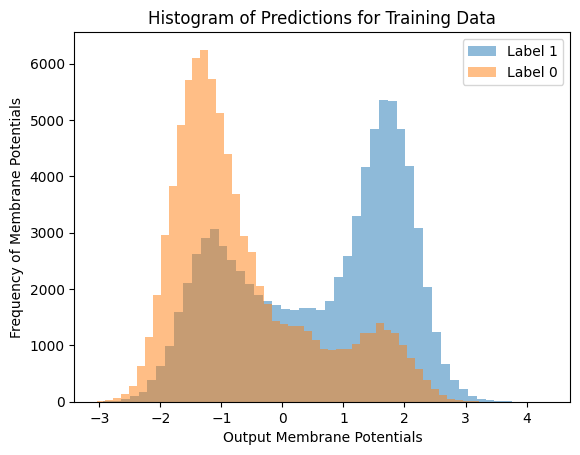

In [7]:
import matplotlib.pyplot as plt

plt.hist(predictions_1_flat, bins=50, alpha=0.5, label='Label 1')
plt.hist(predictions_0_flat, bins=50, alpha=0.5, label='Label 0')

plt.xlabel('Output Membrane Potentials')
plt.ylabel('Frequency of Membrane Potentials')
plt.legend(loc='upper right')
plt.title('Histogram of Predictions for Training Data')
plt.show()

In [8]:
from rockpool.nn.networks import SynNet
import torch

device = torch.device("cpu")

model = SynNet(
    output="vmem",  
    n_channels=16,                        
    n_classes=1,
    dt=10e-3,                           
    size_hidden_layers=[48, 48, 48],
    time_constants_per_layer=[2, 4, 8],
    tau_syn_base=0.02,  
    tau_mem=0.02,
    tau_syn_out=0.02,
    train_threshold = True,
    p_dropout = 0.2
).to(device)


# Load the saved state into the model
model_state_path = 'final_training_results/final_state[48, 48, 48]_[2, 4, 8].pt'
model.load_state_dict(torch.load(model_state_path))
model.to(device)
model.reset_state()
model.eval()

SynNet  with shape (16, 1) {
    TorchSequential 'seq' with shape (16, 1) {
        LinearTorch '0_LinearTorch' with shape (16, 48)
        LIFTorch '1_LIFTorch' with shape (48, 48)
        TimeStepDropout '2_TimeStepDropout' with shape (48,)
        LinearTorch '3_LinearTorch' with shape (48, 48)
        LIFTorch '4_LIFTorch' with shape (48, 48)
        TimeStepDropout '5_TimeStepDropout' with shape (48,)
        LinearTorch '6_LinearTorch' with shape (48, 48)
        LIFTorch '7_LIFTorch' with shape (48, 48)
        TimeStepDropout '8_TimeStepDropout' with shape (48,)
        LinearTorch '9_LinearTorch' with shape (48, 1)
        LIFTorch '10_LIFTorch' with shape (1, 1)
    }
}

In [9]:
import torch
from torch.nn import MSELoss
from tqdm import trange
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
import pickle
import wandb

from torch.utils.data import Dataset, DataLoader, Subset, random_split
import tonic

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

class CCMKDataset(Dataset):
    def __init__(self, spikes_tensor, labels_tensor, nchannels=None, target_label=2, seed=None, device=None):
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.spikes_tensor = spikes_tensor.to(device)
        self.labels_tensor = labels_tensor.to(device)

        if nchannels is not None:
            self.spikes_tensor = self.spikes_tensor[:, nchannels, :]
        
        # Ignore labels 1, 3, and 4
        valid_mask = (self.labels_tensor == 0) | (self.labels_tensor == target_label)
        self.spikes_tensor = self.spikes_tensor[valid_mask]
        self.labels_tensor = self.labels_tensor[valid_mask]
        
        # Convert the target label (2) to 1
        self.labels_tensor[self.labels_tensor == target_label] = 1
        
        # Downsampling: Match the number of label 0 samples to the number of label 1 samples
        label_0_indices = torch.where(self.labels_tensor == 0)[0]
        label_1_indices = torch.where(self.labels_tensor == 1)[0]
        num_samples = min(len(label_1_indices), len(label_0_indices))

        # Randomly sample from label 0 and label 1 indices
        #CPU
        # selected_label_0_indices = torch.tensor(np.random.choice(label_0_indices.cpu(), size=num_samples, replace=False), device=self.device)
        # selected_label_1_indices = torch.tensor(np.random.choice(label_1_indices.cpu(), size=num_samples, replace=False), device=self.device)

        # GPU
        selected_label_0_indices = label_0_indices[torch.randperm(len(label_0_indices))[:num_samples]].to(self.device)
        selected_label_1_indices = label_1_indices[torch.randperm(len(label_1_indices))[:num_samples]].to(self.device)


        # Combine the downsampled label 0 indices with label 1 indices
        balanced_indices = torch.cat([selected_label_0_indices, selected_label_1_indices])

        # Apply the balanced indices to spikes and labels
        self.spikes_tensor = self.spikes_tensor[balanced_indices]
        self.labels_tensor = self.labels_tensor[balanced_indices]

        # Debugging: Check the distribution of labels after processing
        print(f"Filtered Labels distribution after processing: {torch.bincount(self.labels_tensor.int().cpu())}")

    def __len__(self):
        return len(self.labels_tensor)
    
    def __getitem__(self, idx):
        spike_data = self.spikes_tensor[idx]
        label = self.labels_tensor[idx]
        return spike_data, label

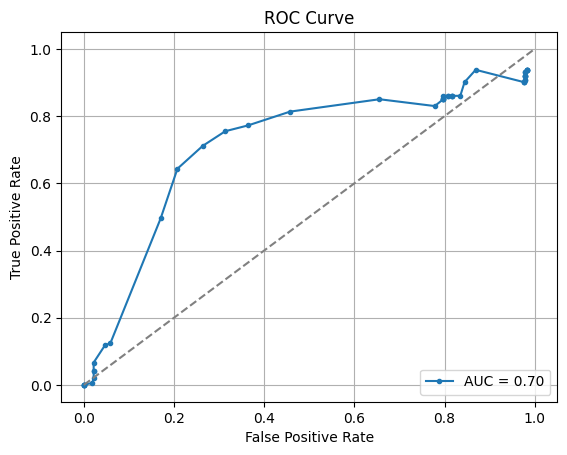

AUC: 0.70


In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
 
test_loader = torch.load('saved_loaders_bs32/test_loader.pth')

threshold_vals = np.arange(0.1, 5., 0.1)
 
def plot_roc_curve_with_confusion_matrix(model, test_loader, threshold_vals):
    TPRs = []
    FPRs = []
    confusion_matrices = {}  
    
    model.output = 'spike'
 
    for th in threshold_vals:
        model.seq[-1].threshold = torch.tensor(th, dtype=torch.float32).to(device)
        
        true_positive = 0
        false_positive = 0
        true_negative = 0
        false_negative = 0
 
        all_predictions = []
        all_labels = []
 
        for inputs, labels in test_loader:
            inputs = inputs.permute(0, 2, 1).to(device)
            labels = labels.to(device)
 
            outputs, _, _ = model(inputs, record=True)
            outputs_sum = outputs.sum(dim=1).detach().cpu().numpy()  
 
            predictions = (outputs_sum > 0).astype(int)
 
            all_predictions.extend(predictions.flatten())  
            all_labels.extend(labels.cpu().numpy().flatten())
 
            true_positive += ((predictions == 1) & (labels.cpu().numpy() == 1)).sum()
            false_positive += ((predictions == 1) & (labels.cpu().numpy() == 0)).sum()
            true_negative += ((predictions == 0) & (labels.cpu().numpy() == 0)).sum()
            false_negative += ((predictions == 0) & (labels.cpu().numpy() == 1)).sum()
 
        # Calculate confusion matrix for this threshold
        cm = confusion_matrix(all_labels, all_predictions)
        confusion_matrices[th] = cm
 
        # Calculate TPR and FPR for the current threshold
        TPR = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0.0
        FPR = false_positive / (false_positive + true_negative) if (false_positive + true_negative) > 0 else 0.0
        
        TPRs.append(TPR)
        FPRs.append(FPR)
 
    sorted_indices = np.argsort(FPRs)
    FPRs_sorted = np.array(FPRs)[sorted_indices]
    TPRs_sorted = np.array(TPRs)[sorted_indices]
 
    auc_value = auc(FPRs_sorted, TPRs_sorted)
 
    plt.figure()
    plt.plot(FPRs_sorted, TPRs_sorted, marker='.', label=f'AUC = {auc_value:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
 
    return TPRs, FPRs, auc_value, confusion_matrices
 
# Compute and plot the ROC curve and confusion matrices
TPRs, FPRs, auc_value, confusion_matrices = plot_roc_curve_with_confusion_matrix(model, test_loader, threshold_vals)
print(f"AUC: {auc_value:.2f}")

In [11]:
from sklearn.metrics import f1_score
 
def find_best_f1_threshold(model, test_loader, threshold_vals):
    best_f1 = 0
    best_threshold = None
 
    for th in threshold_vals:
        model.seq[-1].threshold = torch.tensor(th, dtype=torch.float32).to(device)
        all_predictions = []
        all_labels = []
 
        for inputs, labels in test_loader:
            inputs = inputs.permute(0, 2, 1).to(device)
            labels = labels.to(device)
 
            outputs, _, _ = model(inputs, record=True)
            outputs_sum = outputs.sum(dim=1).detach().cpu().numpy()  
            predictions = (outputs_sum > 0).astype(int)
 
            all_predictions.extend(predictions.flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
 
        # Calculate F1-score
        current_f1 = f1_score(all_labels, all_predictions)
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = th
 
    return best_threshold, best_f1
 
# optimal threshold for the highest F1-score
best_threshold, best_f1 = find_best_f1_threshold(model, test_loader, threshold_vals)
print(f"The optimal threshold based on F1-score is {best_threshold} with an F1 score of {best_f1:.2f}")
 

The optimal threshold based on F1-score is 3.4000000000000004 with an F1 score of 0.76


Accuracy: 0.75
Precision: 0.74
Recall: 0.79
F1-score: 0.76
Confusion Matrix:
 [[76 30]
 [22 84]]


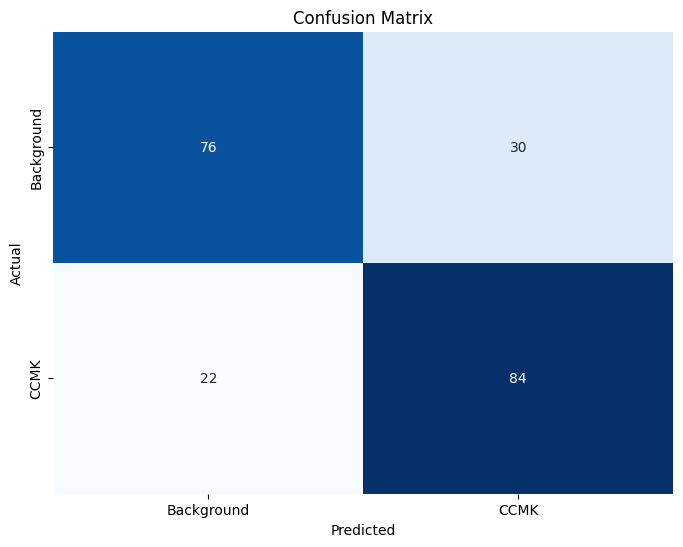

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
 
def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Background', 'CCMK'], yticklabels=['Background', 'CCMK'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
 
# Function to evaluate the model with the optimal threshold
def evaluate_model_with_threshold(model, test_loader, threshold):
    model.seq[-1].threshold = torch.tensor(threshold, dtype=torch.float32).to(device)
 
    all_predictions = []
    all_labels = []
 
    for inputs, labels in test_loader:
        inputs = inputs.permute(0, 2, 1).to(device)  
        labels = labels.to(device)
 
        outputs, _, _ = model(inputs, record=True)
        outputs_sum = outputs.sum(dim=1).detach().cpu().numpy()
 
        # Apply optimal threshold to predictions
        predictions = (outputs_sum > 0).astype(int)
 
        all_predictions.extend(predictions.flatten())
        all_labels.extend(labels.cpu().numpy().flatten())
 
    # Calculate metrics
    acc = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    cm = confusion_matrix(all_labels, all_predictions)
 
    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")
    print("Confusion Matrix:\n", cm)
 
    return all_labels, all_predictions, cm
 
all_labels, all_predictions, cm = evaluate_model_with_threshold(model, test_loader, 3.4)
 
plot_confusion_matrix(cm)
 

In [13]:
# Function to calculate the miss rate for each class
def calculate_miss_rate(cm, class_labels=['Background', 'CCMK']):
    tn, fp, fn, tp = cm.ravel()  
 
    # Calculate miss rate for each class
    miss_rate_ccmk = fn / (fn + tp) if (fn + tp) > 0 else 0  
    miss_rate_background = fp / (fp + tn) if (fp + tn) > 0 else 0
 
    print(f"Miss Rate for CCMK (Class 1): {miss_rate_ccmk:.4f}")
    print(f"Miss Rate for Background (Class 0): {miss_rate_background:.4f}")
 
    return miss_rate_ccmk, miss_rate_background
 
miss_rate_ccmk, miss_rate_background = calculate_miss_rate(cm)
 

Miss Rate for CCMK (Class 1): 0.2075
Miss Rate for Background (Class 0): 0.2830


In [14]:
# Function to calculate the False Detection Rate (FDR) for each class
def calculate_false_detection_rate(cm, class_labels=['Background', 'CCMK']):
    tn, fp, fn, tp = cm.ravel()  
 
    # Calculate False Detection Rate for each class
    fdr_ccmk = fp / (fp + tp) if (fp + tp) > 0 else 0  
    fdr_background = fn / (fn + tn) if (fn + tn) > 0 else 0  
 
    print(f"False Detection Rate for CCMK (Class 1): {fdr_ccmk:.4f}")
    print(f"False Detection Rate for Background (Class 0): {fdr_background:.4f}")
 
    return fdr_ccmk, fdr_background
 
fdr_ccmk, fdr_background = calculate_false_detection_rate(cm)

False Detection Rate for CCMK (Class 1): 0.2632
False Detection Rate for Background (Class 0): 0.2245


## Simulation

In [15]:
# - Import chip simulation tools    
from rockpool.devices.xylo.syns61201 import XyloSim, mapper, config_from_specification
from rockpool.transform.quantize_methods import channel_quantize

In [16]:
import torch

# - Map the model to the HW architecture
model.seq[-1].threshold = torch.tensor(1.0).to(device)
spec = mapper(model.as_graph())

# - Quantize the model
Q_spec = spec
Q_spec.update(channel_quantize(**Q_spec))

# - Get a hardware configuration
config, is_valid, msg = config_from_specification(**Q_spec)
if not is_valid:
    print(msg)

In [17]:
modSim = XyloSim.from_config(config, dt = model.dt)

In [18]:
modSim

XyloSim  with shape (16, 1000, 8)

In [20]:
train_loader = torch.load('saved_loaders_bs32/train_loader.pth')
val_loader = torch.load('saved_loaders_bs32/val_loader.pth')
test_loader = torch.load('saved_loaders_bs32/test_loader.pth')

In [24]:
for batch in train_loader:
    inputs, labels = batch
    print("Labels in the training set batch:", labels) 
    break

Labels in the training set batch: tensor([0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 1])


In [21]:
# Check a single batch from the train loader
for inputs, targets in train_loader:
    print(f"Sample inputs shape: {inputs.shape}")
    print(f"Sample targets shape: {targets.shape}")
    break  


Sample inputs shape: torch.Size([32, 16, 101])
Sample targets shape: torch.Size([32])


In [22]:
out, _, record_dict = modSim(inputs[0].numpy().T, record = True)

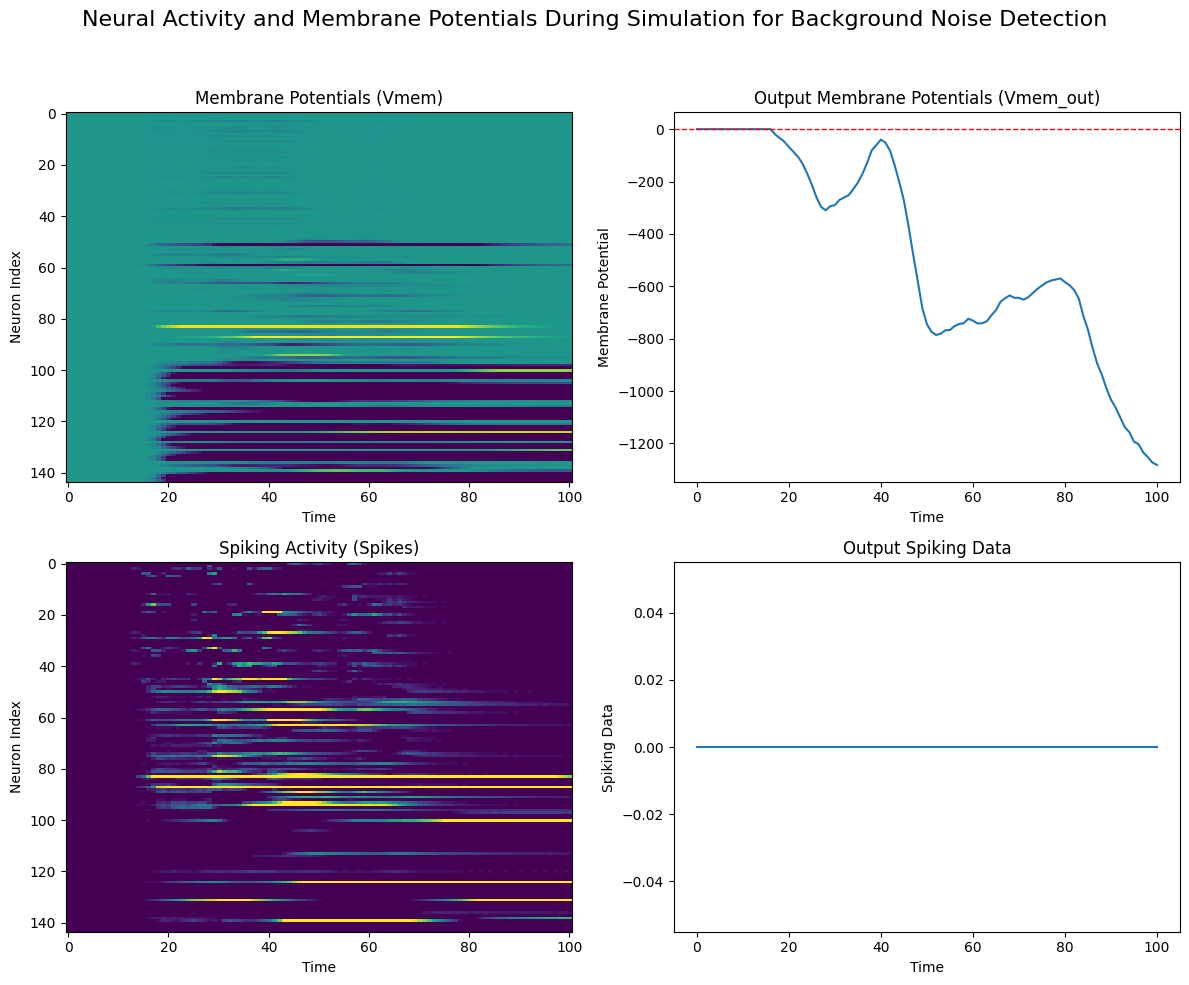

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  

# First subplot: record_dict['Vmem']
axes[0, 0].imshow(record_dict['Vmem'].T, aspect='auto', cmap='viridis', interpolation='none')
axes[0, 0].set_title('Membrane Potentials (Vmem)')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Neuron Index')

# Second subplot: record_dict['Vmem_out']
axes[0, 1].plot(record_dict['Vmem_out'])
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=1)  # Add red dashed line at y=0
axes[0, 1].set_title('Output Membrane Potentials (Vmem_out)')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Membrane Potential')

# Third subplot: record_dict['Spikes']
axes[1, 0].imshow(record_dict['Spikes'].T, aspect='auto', cmap='viridis', interpolation='none')
axes[1, 0].set_title('Spiking Activity (Spikes)')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Neuron Index')

# Fourth subplot: 'out'
axes[1, 1].plot(out)
axes[1, 1].set_title('Output Spiking Data')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Spiking Data')

fig.suptitle('Neural Activity and Membrane Potentials During Simulation for Target Class (CCMK) Detection', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

In [27]:
out, _, record_dict = modSim(inputs[9].numpy().T, record = True)

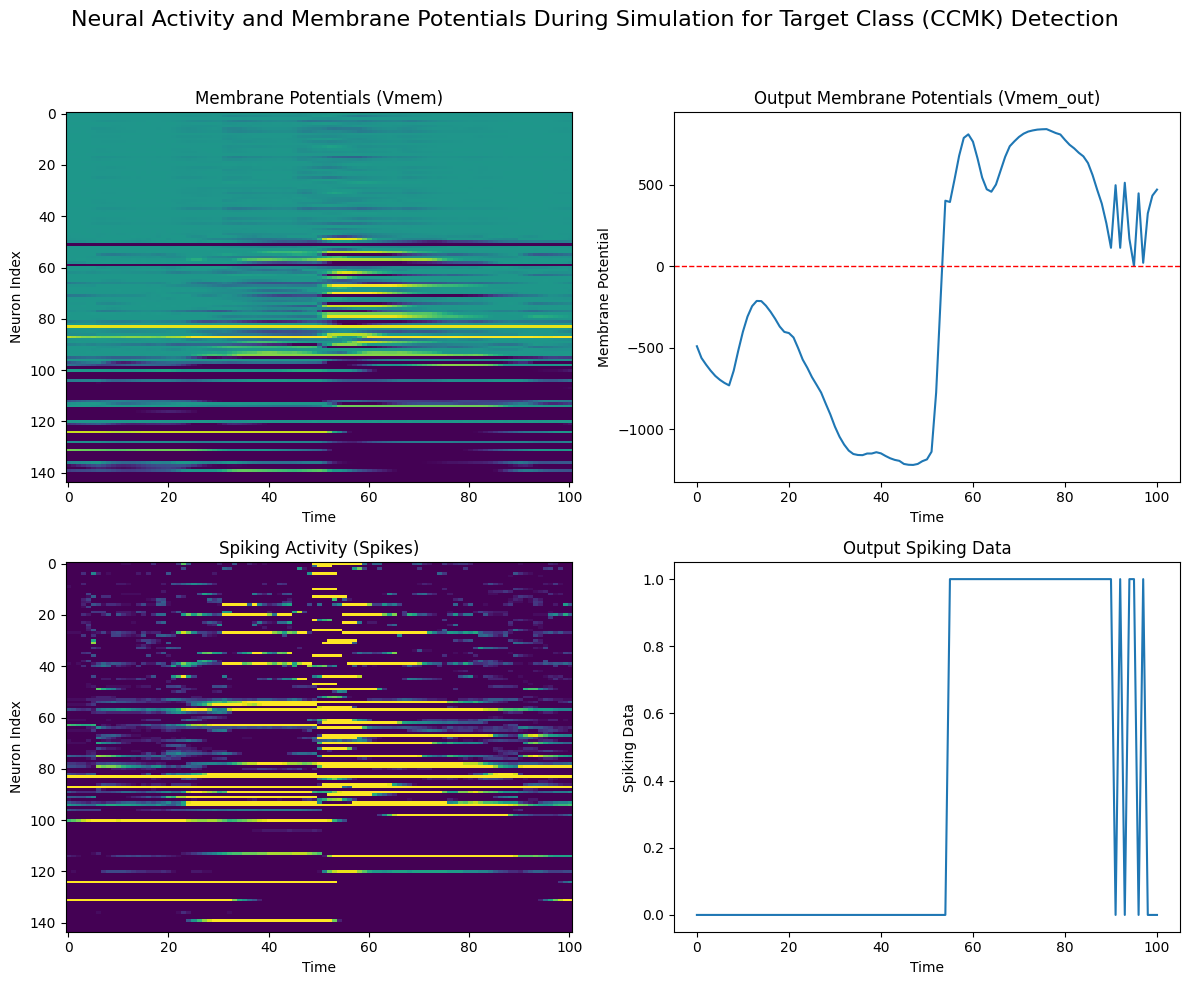

In [28]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  

# First subplot: record_dict['Vmem']
axes[0, 0].imshow(record_dict['Vmem'].T, aspect='auto', cmap='viridis', interpolation='none')
axes[0, 0].set_title('Membrane Potentials (Vmem)')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Neuron Index')

# Second subplot: record_dict['Vmem_out']
axes[0, 1].plot(record_dict['Vmem_out'])
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=1)  # Add red dashed line at y=0
axes[0, 1].set_title('Output Membrane Potentials (Vmem_out)')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Membrane Potential')

# Third subplot: record_dict['Spikes']
axes[1, 0].imshow(record_dict['Spikes'].T, aspect='auto', cmap='viridis', interpolation='none')
axes[1, 0].set_title('Spiking Activity (Spikes)')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Neuron Index')

# Fourth subplot: 'out'
axes[1, 1].plot(out)
axes[1, 1].set_title('Output Spiking Data')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Spiking Data')

fig.suptitle('Neural Activity and Membrane Potentials During Simulation for Target Class (CCMK) Detection', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()